In [1]:
import eurec4a
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
from cycler import cycler
import pandas as pd

In [2]:
cat = eurec4a.get_intake_catalog()
botany_cat = cat.simulations.DALES.botany
ds_1d_1536 = botany_cat.dx100m.nx1536['profiles'].to_dask()

varied_parameters = ['member','thls', 'u0', 'qt0', 'qt_lambda', 'thl_Gamma', 'wpamp', 'dudz', 'location']
parameters = cat.simulations.DALES.botany.dx100m.nx1536.parameters.read()
df_parameters = pd.DataFrame.from_records(parameters)[varied_parameters]
df_parameters['qt_lambda'] = df_parameters['qt_lambda']/1000

In [3]:
def plot_per_parameter(var, var_lab, z_coord='zt', zlim=4000, legend=False, xmin=None, xmax=None, fac=1, normalise=False, in_ds=True, ds_in=None):

    # Last 24 h
    t_sel_min_d = '2020-02-02 12:00:00'
    t_sel_max_d = '2020-02-03 12:00:00'

    sweep_pars = ['thls', 'u0', 'thl_Gamma', 'qt_lambda', 'wpamp',]
    sweep_lab = [r"$\theta_{l0}$", r"$u_0$", r"$\Gamma$",  r"$h_{q_t}$", r"$w_{1}$"]
    unit_lab = [r"[K]", r"[m/s]", r"[K/km]",  r"[km]", r"[m/s]"]
    anno = ['a)', 'b)', 'c)', 'd)', 'e)']

    fig,axs = plt.subplots(nrows=1,ncols=5,figsize=(12, 3), sharex=True, sharey=True, squeeze=False)
    plt.subplots_adjust(wspace=0.5)
    sns.despine(offset=5)

    for (i, pari) in enumerate(sweep_pars):
        
        # Add to the profiles output
        ds_u = ds_1d_1536.assign(df_parameters[['member',pari,'location']]
                                 .set_index('member')
                                 .to_xarray())
        
        # Filter on sweep location
        ds_u = ds_u.where((ds_u.location=='sweep '+pari) | (ds_u.location=='center'), drop=True)

        # Select only second day
        ds_u = ds_u.sel(time=slice(t_sel_min_d, t_sel_max_d)).mean('time')

        # Drop the center if thls or thl_gamma or wpamp:
        if pari == 'thl_Gamma' or pari == 'wpamp':
            ds_u = ds_u.where(ds_u.location=='sweep '+pari, drop=True)
        
        # Drop the first point if Us (too strong wind)
        if pari == 'u0':
            ds_u = ds_u.where(ds_u[pari] > -12, drop=True)
            ds_u[pari] = -ds_u[pari] # Make positive

        # Drop the least stable case for thl_Gamma (deep conv), and a central case where statistics aren't robust
        if pari == 'thl_Gamma':
            ds_u = ds_u.where(ds_u[pari] > 4.5, drop=True)
            ds_u = ds_u.where(ds_u[pari] != 5.5, drop=True)

        # Drop the moistest/driest qt_lambda (crazy things going on that I don't understand)
        if pari == 'qt_lambda':
            ds_u = ds_u.where(ds_u[pari] > 0.8, drop=True)
            ds_u = ds_u.where(ds_u[pari] != 2.5, drop=True)

        # Filter height
        if z_coord == 'zt':
            ds_u = ds_u.sel(zt=slice(0,zlim))
        elif z_coord == 'zm':
            ds_u = ds_u.sel(zm=slice(0,zlim))

        # Group by pari and scale
        ds_grouped = ds_u[[var,pari]].groupby(pari)
        ds_grouped_mn = ds_grouped.mean().compute()*fac

        # 1536
        axs[0,i].set_prop_cycle(cycler(color=plt.cm.viridis(np.linspace(0, 1, len(ds_grouped.groups)))))
        for j in range(len(ds_grouped.groups)):
            varplt = ds_grouped_mn[var].where(ds_grouped_mn[pari] == ds_grouped_mn[pari][j], drop=True).values.flatten()
            axs[0,i].plot(varplt, ds_u[z_coord], label=ds_grouped_mn[pari][j].values)
        if legend:
            axs[0,i].legend(frameon=False, bbox_to_anchor=(0.6,1), loc='upper left', title=sweep_lab[i] + ' ' + unit_lab[i])
#         axs[0,i].set_title(sweep_lab[i])
        axs[0,i].set_xlabel('')
        if i == 0:
            axs[0,i].set_ylabel('Height [m]')
        else:
            axs[0,i].set_ylabel('')
        axs[0,i].annotate(anno[i], (0.1, 0.95), xycoords='axes fraction')

        if type(xmin) != type(None):
            axs[0,0].set_xlim(xmin, xmax)

        axs[0,i].set_xlabel(var_lab)
            
    return axs

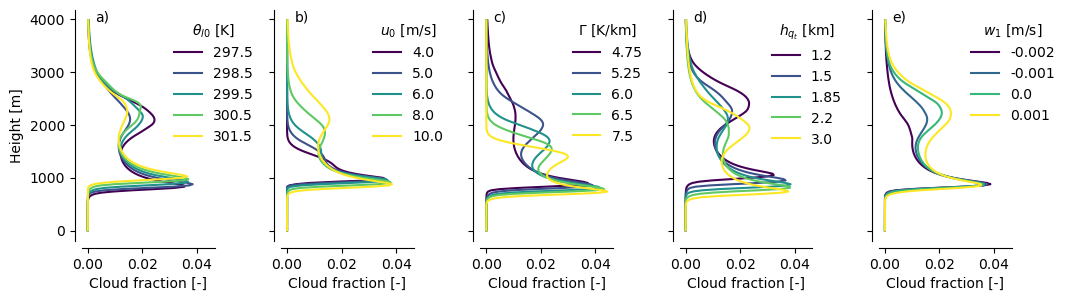

In [4]:
var = 'cfrac'
var_lab = 'Cloud fraction [-]'
axs = plot_per_parameter(var, var_lab, legend=True)
plt.savefig('cfrac-profiles-sweeps.pdf', bbox_inches='tight')